# Control Analysis: Permuting connectivity matrices

In [20]:
import numpy as np
import pickle
import nibabel as nib
from sklearn import metrics as skm
from tqdm import tqdm
import seaborn as sns
import scipy.stats as stats

import wbplot
import matplotlib.image as img
import matplotlib.colors as clrs
from matplotlib import colorbar

import plottools
import RSMtools

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Paths
projdir = '/home/ln275/f_mc1689_1/multitask_generalization/'
fcdir = projdir + 'data/derivatives/FC_new/'
fcoutdir = fcdir+ 'vertexwiseFC/'
figoutdir = projdir + 'docs/figures/working/vertexwiseFC/'
helpfiles_dir = projdir + 'docs/experimentfiles/'
glasser_parcels_dir = helpfiles_dir + 'dilated_glasser_parcel_dscalar_files/'
subProjDir = projdir + 'data/derivatives/RSM_ActFlow/'

In [3]:
# Params and helpfiles
subIDs=['02','03','06','08','10','12','14','18','20',
        '22','24','25','26','27','28','29','30','31']

# Use when dealing with full subjects' data (n=24)
onlyRestSubIdx = [ 0, 1, 3, 4, 6, 7, 8,10,11,
                  12,20,13,21,14,22,15,23,16] 
nSub = len(subIDs)
nParcels = 360
nVertices = 59412
nSessions = 2
nPerm = 100

glasserfilename = helpfiles_dir + 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())
networkdef = np.loadtxt(helpfiles_dir + 'cortex_parcel_network_assignments.txt')
networkNames = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMULTI','VMM','ORA']

In [4]:
# reading parcel-level FC

with open(fcdir + 'allSubFC_parCorr.pkl', 'rb') as f:
    allSubParCorr = pickle.load(f)

In [5]:
# Get source vertices for each target
with open(fcdir + 'allSub_sourcevert_sourcelabels_bytarget.pkl', 'rb') as f:
    allsub_sourcevert_sourcelabels = pickle.load(f)

In [6]:
# Task data

# Task conditions subset (active visual task conditions)
nTaskCond_select = 96 # excluding passive tasks and interval timing (auditory task)

TaskCondIdx_subset = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,36,37,38,39,40,
                      41,42,43,44,45,46,49,50,51,52,53,54,55,56,60,61,62,63,64,65,
                      66,67,68,69,70,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,
                      87,88,89,91,92,93,94,95,96,97,98,99,100,101,102,104,105,106,
                      107,108,109,110,111,112,113,114,115,120,121,122,123,124,125])

with open(subProjDir + 'allSubTaskCondBetas.pkl', 'rb') as f:
    allSubTaskBetas = pickle.load(f)
    
selectsub_selecttaskcond_TaskBetas = allSubTaskBetas[onlyRestSubIdx,:,:,:][:,:,TaskCondIdx_subset,:]
meantaskcond_meansess_obs_TaskBetas = np.mean(selectsub_selecttaskcond_TaskBetas,axis=(1,2))

In [7]:
def compute_cross_validated_cosine_similarity(data):
    """
    Compute the cross-validated cosine similarity matrix between tasks.
    
    Parameters:
    data: numpy array of shape (n, v, 2)
          where n is the number of tasks, v is the number of vertices, and 2 is the number of sessions
    
    Returns:
    similarity_matrix: numpy array of shape (n, n)
                       cross-validated cosine similarity matrix between tasks
    """
    # Separate the data into two sessions
    session1 = data[:, :, 0]
    session2 = data[:, :, 1]

    # Normalize each task's activity pattern for both sessions
    session1_normed = session1 / np.linalg.norm(session1, axis=1, keepdims=True)
    session2_normed = session2 / np.linalg.norm(session2, axis=1, keepdims=True)

    # Compute the cross-validated cosine similarity matrix
    similarity_matrix = np.dot(session1_normed, session2_normed.T)
    
    return similarity_matrix

In [15]:
# Compute RSM connperm

RSM_connperm = np.zeros((nSub,nParcels,nTaskCond_select,nTaskCond_select,nPerm))

# Read each subject's conn perm betas

for subIdx in range(nSub):

    print('subIdx:',subIdx)
    
    with open(subProjDir + subIDs[subIdx] + '_actflow_pred_betas_connperm.pkl', 'rb') as f:
        thisSub_predBetas_connPerm = pickle.load(f)


    with tqdm(total=nParcels, desc="Progress") as pbar:

        for roiIdx in range(nParcels):

            for permIdx in range(nPerm):

                betas_data = thisSub_predBetas_connPerm[roiIdx][:,:,:,permIdx]

                RSM_connperm[subIdx,roiIdx,:,:,permIdx] = compute_cross_validated_cosine_similarity(betas_data)

            pbar.update(1)
            
with open(subProjDir + 'allsub_actflow_pred_RSM_connperm.pkl', 'wb') as f:
        pickle.dump(RSM_connperm,f)

subIdx: 0


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.10it/s]


subIdx: 1


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.35it/s]


subIdx: 2


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.47it/s]


subIdx: 3


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.41it/s]


subIdx: 4


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.62it/s]


subIdx: 5


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.20it/s]


subIdx: 6


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.52it/s]


subIdx: 7


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.57it/s]


subIdx: 8


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.30it/s]


subIdx: 9


Progress: 100%|██████████| 360/360 [00:12<00:00, 29.93it/s]


subIdx: 10


Progress: 100%|██████████| 360/360 [00:12<00:00, 29.41it/s]


subIdx: 11


Progress: 100%|██████████| 360/360 [00:12<00:00, 29.67it/s]


subIdx: 12


Progress: 100%|██████████| 360/360 [00:12<00:00, 29.72it/s]


subIdx: 13


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.19it/s]


subIdx: 14


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.28it/s]


subIdx: 15


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.34it/s]


subIdx: 16


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.18it/s]


subIdx: 17


Progress: 100%|██████████| 360/360 [00:11<00:00, 30.65it/s]


In [ ]:
# Compute RSM connperm

RSM_connperm = np.zeros((nSub,nParcels,nTaskCond_select,nTaskCond_select,nPerm))

# Read each subject's conn perm betas

for subIdx in range(nSub):

    print('subIdx:',subIdx)
    
    with open(subProjDir + subIDs[subIdx] + '_actflow_pred_betas_connperm.pkl', 'rb') as f:
        thisSub_predBetas_connPerm = pickle.load(f)


    with tqdm(total=nParcels, desc="Progress") as pbar:

        for roiIdx in range(nParcels):

            for permIdx in range(nPerm):

                betas_data = thisSub_predBetas_connPerm[roiIdx][:,:,:,permIdx]

                RSM_connperm[subIdx,roiIdx,:,:,permIdx] = compute_cross_validated_cosine_similarity(betas_data)

            pbar.update(1)
            
with open(subProjDir + 'allsub_actflow_pred_RSM_connperm.pkl', 'wb') as f:
        pickle.dump(RSM_connperm,f)

In [16]:
# Compute pred betas conn perm pearson r

r_arr_connperm_betas = np.zeros((nSub,nParcels,nPerm))

# Read each subject's conn perm betas

for subIdx in range(nSub):

    print('subIdx:',subIdx)
    
    with open(subProjDir + subIDs[subIdx] + '_actflow_pred_betas_connperm.pkl', 'rb') as f:
        thisSub_predBetas_connPerm = pickle.load(f)

    for targetroi_idx in range(nParcels):

        meantaskcond_meansess_pred_TaskBetas_connperm = np.mean(thisSub_predBetas_connPerm[targetroi_idx],axis=(0,2))
        
        target_vert = np.where(glasser == targetroi_idx+1)[0]

        obs = meantaskcond_meansess_obs_TaskBetas[subIdx,target_vert]
        
        for permIdx in range(nPerm):
        
            pred = meantaskcond_meansess_pred_TaskBetas_connperm[:,permIdx]

            r,p = stats.pearsonr(obs,pred)

            r_arr_connperm_betas[subIdx,targetroi_idx,permIdx] = r
        
with open(subProjDir + 'allsub_meantaskcond_meansess_TaskBetas_comparison_r_connperm.pkl', 'wb') as f:
        pickle.dump(r_arr_connperm_betas,f)

subIdx: 0
subIdx: 1
subIdx: 2
subIdx: 3
subIdx: 4
subIdx: 5
subIdx: 6
subIdx: 7
subIdx: 8
subIdx: 9
subIdx: 10
subIdx: 11
subIdx: 12
subIdx: 13
subIdx: 14
subIdx: 15
subIdx: 16
subIdx: 17


In [7]:
# Reading back

with open(subProjDir + 'allsub_meantaskcond_meansess_TaskBetas_comparison_r_connperm.pkl', 'rb') as f:
        r_arr_connperm_betas = pickle.load(f)

In [8]:
r_arr_connperm_betas.shape

(18, 360, 100)

In [9]:
# Reading observed prediction estimates

with open(subProjDir + 'allsub_meantaskcond_meansess_TaskBetas_comparison_r_rsq.pkl', 'rb') as f:
        meantaskcond_meansess_TaskBetas_comparison_r_arr = pickle.load(f)

In [10]:
meantaskcond_meansess_TaskBetas_comparison_r_arr.shape

(18, 360)

In [11]:
# Generate 1000 group-level means by bootstrapping

n_groupnull = 1000
groupiter_connpermbetas_mean = np.zeros((nParcels,n_groupnull))

for groupnullIdx in range(n_groupnull):
    
    this_groupiter_connpermbetas = []

    for subIdx in range(nSub):

        this_groupiter_connpermbetas.append(r_arr_connperm_betas[subIdx,:,np.random.randint(0, nPerm)])

    groupiter_connpermbetas_mean[:,groupnullIdx] = np.mean(np.array(this_groupiter_connpermbetas),axis=0)
    
groupiter_connpermbetas_mean.shape

(360, 1000)

In [12]:
meansub_r_arr_connperm_betas = np.mean(r_arr_connperm_betas,axis=0)
meansub_meantaskcond_meansess_TaskBetas_comparison_r_arr = np.mean(meantaskcond_meansess_TaskBetas_comparison_r_arr,axis=0)

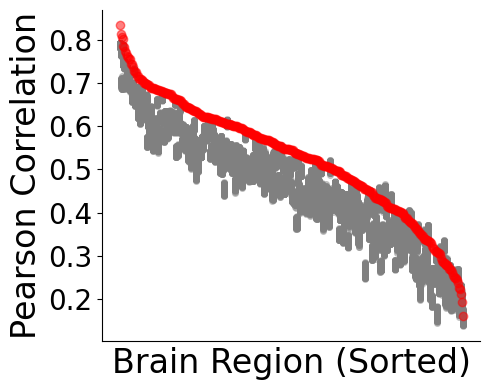

In [13]:

observed_values = meansub_meantaskcond_meansess_TaskBetas_comparison_r_arr
null_distributions = groupiter_connpermbetas_mean
# noise_ceil = meansub_obs_betas_crossessionreliability_r_meantaskcond

# Assume observed_values is a (360,) array of observed mean values
# And null_distributions is a (360, 1000) array for null distributions

# Step 1: Sort the regions by observed means
sorted_indices = np.argsort(observed_values)[::-1]  # Sort in descending order

# Reorder the observed values and null distributions
observed_values_sorted = observed_values[sorted_indices]
null_distributions_sorted = null_distributions[sorted_indices, :]
# noise_ceil_sorted = noise_ceil[sorted_indices]

# Step 2: Prepare data for strip plot
data = []
for i in range(nParcels):
    for j in range(n_groupnull):
        data.append([i, null_distributions_sorted[i, j]])
        
df = pd.DataFrame(data, columns=['Region', 'Null Value'])

# Step 3: Create the strip plot
plt.figure(figsize=(5, 4))

sns.stripplot(x='Region', y='Null Value', data=df, jitter=True, alpha=0.5, color='gray')

# # Overlay the noise ceil
# plt.scatter(x=np.arange(nParcels), y=noise_ceil_sorted, color='gray',marker='_', label='Noise Ceiling', zorder=9)

# Overlay the observed values
plt.scatter(x=np.arange(nParcels), y=observed_values_sorted, color='red', alpha=0.5,label=None, zorder=10)
plt.xticks([])
plt.yticks(fontsize=20)

#plt.title('Null Distributions and Observed Values (Sorted by Observed Means)')
plt.xlabel('Brain Region (Sorted)',fontsize=24)
plt.ylabel('Pearson Correlation',fontsize=24)
# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'Actflow_betas_prediction_wConnPerm.pdf',transparent=True)

plt.show()

In [14]:
n_instances = np.sum(np.tile(observed_values_sorted,(1000,1)).T < null_distributions_sorted, axis=1)
pval = n_instances/1000
print('pval < 0.001:', np.sum(pval < 0.001))
print('pval < 0.05:', np.sum(pval < 0.05))

pval < 0.001: 328
pval < 0.05: 337


In [16]:
meansub_meantaskcond_meansess_TaskBetas_comparison_r_arr_sig = np.where(
    pval < 0.05, meansub_meantaskcond_meansess_TaskBetas_comparison_r_arr, 0)

In [18]:
# Brain plot: Move to utils later

def get_brain_plot(inputdata,file_out,title,ignore_zero=False):

    #flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
    inputdata_flipped=np.zeros(np.shape(inputdata))
    inputdata_flipped[0:180]=inputdata[180:360]
    inputdata_flipped[180:360]=inputdata[0:180]

    if ignore_zero:
        non_zero_mask = inputdata != 0
        min_inputdata = np.min(inputdata[non_zero_mask])
    else:
        min_inputdata = np.min(inputdata)
    
    # Set to all reds if no negative values
    if min_inputdata >= 0:
        colormap='Reds'
        vmin, vmax = min_inputdata, np.max(inputdata)
    else:
        colormap='seismic'
        limit = np.max([np.abs(min_inputdata), np.abs(np.max(inputdata))])
        vmin,vmax = -1*limit, limit

    wbplot.pscalar(
            file_out=figoutdir + file_out + '.png',
            pscalars=inputdata_flipped,
            vrange = (vmin,vmax),
            cmap=colormap,
            transparent=True)

    plt.figure(figsize=(3.5,3))
    ax = plt.subplot(111)
    im = img.imread(figoutdir + file_out + '.png') 
    plt.imshow(im)
    plt.axis('off')
    plt.title(title,fontsize=18)

    # vmin, vmax = -2, 2
    cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
    cmap = plt.get_cmap(colormap)
    cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
    cbar = colorbar.ColorbarBase(
        cax, cmap=cmap, norm=cnorm, orientation='horizontal')
    #cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
    cax.get_xaxis().set_tick_params(length=0, pad=-2)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)
    cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
             fontsize=12);
    cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
             fontsize=12);
    plt.tight_layout()
    plt.savefig(figoutdir + file_out + '.pdf',transparent=True) 

pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.050181 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.01994 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.030674 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.019437 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.051632 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.020918 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.031474 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.019111 seconds.


Info: 

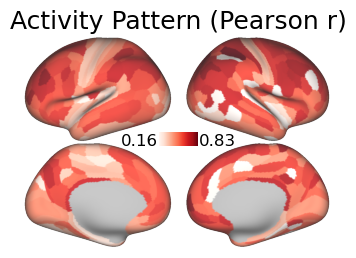

In [21]:
file_out = 'ActPattComparison_r'
inputdata = meansub_meantaskcond_meansess_TaskBetas_comparison_r_arr_sig
title = 'Activity Pattern (Pearson r)'

get_brain_plot(inputdata,file_out,title,ignore_zero=True)

### RSM comparison

In [22]:
# Reading in the permuted RSMs

with open(subProjDir + 'allsub_actflow_pred_RSM_connperm.pkl', 'rb') as f:
        RSM_connperm = pickle.load(f)

In [23]:
RSM_connperm.shape

(18, 360, 96, 96, 100)

In [24]:
# Observed RSMs:

with open(subProjDir + 'allsub_taskCond_RSM_activeVisual.pkl', 'rb') as f:
    allsub_taskCondRSM = pickle.load(f)
    
select_sub_taskCondRSM = allsub_taskCondRSM[onlyRestSubIdx,:,:,:] # rest data's available only for 18 sub

In [25]:
select_sub_taskCondRSM.shape

(18, 360, 96, 96)

In [30]:
# Compute pred RSM conn perm cosine similarity

cosSim_arr_connperm_RSM = np.zeros((nSub,nParcels,nPerm))

# Read each subject's conn perm RSM

for subIdx in range(nSub):

    print('subIdx:',subIdx)

    for targetroi_idx in range(nParcels):

        obs = select_sub_taskCondRSM[subIdx,targetroi_idx,:,:].flatten()
        obsRSM_flat_normed = obs / np.linalg.norm(obs)
        
        for permIdx in range(nPerm):
        
            pred = RSM_connperm[subIdx,targetroi_idx,:,:,permIdx].flatten()
            predRSM_flat_normed = pred / np.linalg.norm(pred)

            cosSim = np.dot(obsRSM_flat_normed, predRSM_flat_normed.T)

            cosSim_arr_connperm_RSM[subIdx,targetroi_idx,permIdx] = cosSim
        
with open(subProjDir + 'allsub_meantaskcond_meansess_RSM_comparison_cosSim_connperm.pkl', 'wb') as f:
        pickle.dump(cosSim_arr_connperm_RSM,f)

subIdx: 0
subIdx: 1
subIdx: 2
subIdx: 3
subIdx: 4
subIdx: 5
subIdx: 6
subIdx: 7
subIdx: 8
subIdx: 9
subIdx: 10
subIdx: 11
subIdx: 12
subIdx: 13
subIdx: 14
subIdx: 15
subIdx: 16
subIdx: 17


In [26]:
with open(subProjDir + 'allsub_meantaskcond_meansess_RSM_comparison_cosSim_connperm.pkl', 'rb') as f:
        cosSim_arr_connperm_RSM = pickle.load(f)

In [27]:
# Generate 1000 group-level means by bootstrapping

n_groupnull = 1000
groupiter_connpermRSM_mean = np.zeros((nParcels,n_groupnull))

for groupnullIdx in range(n_groupnull):
    
    this_groupiter_connpermRSM = []

    for subIdx in range(nSub):

        this_groupiter_connpermRSM.append(cosSim_arr_connperm_RSM[subIdx,:,np.random.randint(0, nPerm)])

    groupiter_connpermRSM_mean[:,groupnullIdx] = np.mean(np.array(this_groupiter_connpermRSM),axis=0)
    
groupiter_connpermRSM_mean.shape

(360, 1000)

In [28]:
# Reading obsered r values

with open(subProjDir + 'allsub_obs_vs_actflowpredRSM_compar.pkl', 'rb') as f:
    RSM_obs_vs_pred_cosSim = pickle.load(f)

In [35]:
RSM_obs_vs_pred_cosSim.shape

(18, 360)

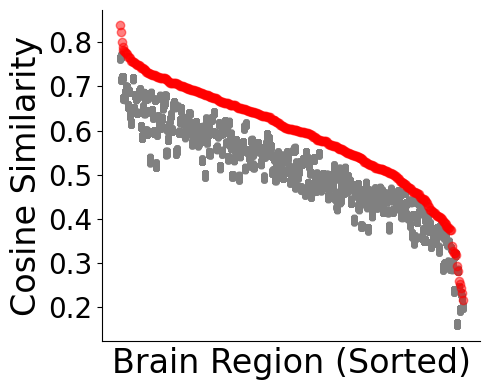

In [29]:
observed_values = np.mean(RSM_obs_vs_pred_cosSim,axis=0)
null_distributions = groupiter_connpermRSM_mean
#noise_ceil = np.mean(RSM_noiseCeil_r_arr,axis=0)

# Assume observed_values is a (360,) array of observed mean values
# And null_distributions is a (360, 1000) array for null distributions

# Step 1: Sort the regions by observed means
sorted_indices = np.argsort(observed_values)[::-1]  # Sort in descending order

# Reorder the observed values and null distributions
observed_values_sorted = observed_values[sorted_indices]
null_distributions_sorted = null_distributions[sorted_indices, :]
#noise_ceil_sorted = noise_ceil[sorted_indices]

# Step 2: Prepare data for strip plot
data = []
for i in range(nParcels):
    for j in range(n_groupnull):
        data.append([i, null_distributions_sorted[i, j]])
        
df = pd.DataFrame(data, columns=['Region', 'Null Value'])

# Step 3: Create the strip plot
plt.figure(figsize=(5, 4))

sns.stripplot(x='Region', y='Null Value', data=df, jitter=True, alpha=0.5, color='gray')

# # Overlay the noise ceil
# plt.scatter(x=np.arange(nParcels), y=noise_ceil_sorted, color='gray',marker='_', label='Noise Ceiling', zorder=9)

# Overlay the observed values
plt.scatter(x=np.arange(nParcels), y=observed_values_sorted, color='red', alpha=0.5, label=None, zorder=10)
plt.xticks([])
plt.yticks(fontsize=20)

#plt.title('Null Distributions and Observed Values (Sorted by Observed Means)')
plt.xlabel('Brain Region (Sorted)',fontsize=24)
plt.ylabel('Cosine Similarity',fontsize=24)
# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'Actflow_RSM_prediction_wConnPerm.pdf',transparent=True)

plt.show()

In [30]:
n_instances = np.sum(np.tile(observed_values_sorted,(1000,1)).T < null_distributions_sorted, axis=1)
pval = n_instances/1000
print(np.sum(pval < 0.05))

358


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.050265 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.020361 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.031434 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.018603 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.048555 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.019905 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.030744 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.018757 seconds.


Info:

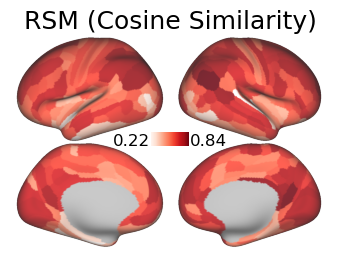

In [31]:
meansub_RSM_obs_vs_pred_cosSim = np.mean(RSM_obs_vs_pred_cosSim,axis=0)
meansub_RSM_obs_vs_pred_cosSim_sig = np.where(pval<0.05, meansub_RSM_obs_vs_pred_cosSim, 0)

file_out = 'RSMComparison_cosSim'
inputdata = meansub_RSM_obs_vs_pred_cosSim_sig
title = 'RSM (Cosine Similarity)'

get_brain_plot(inputdata,file_out,title,ignore_zero=True)

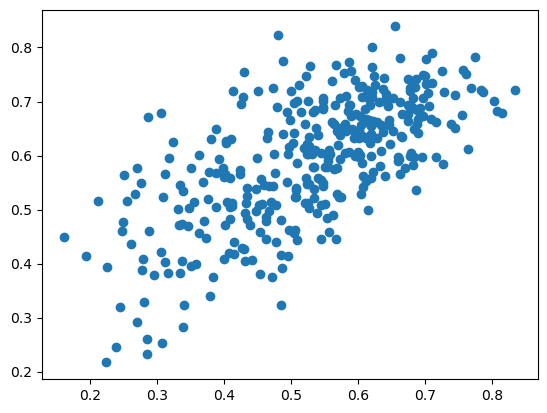

PearsonRResult(statistic=0.6705822859893528, pvalue=2.3271912680791528e-48)

In [84]:
# Is RSM prediction just a derivative of activity pattern prediction?

Y = np.mean(RSM_obs_vs_pred_cosSim,axis=0)
X = meansub_meantaskcond_meansess_TaskBetas_comparison_r_arr

plt.scatter(X,Y)
plt.show()

stats.pearsonr(X,Y)

### Dimensionality comparison 

In [37]:
# Compute dimensionality

def getDimensionality(data):
    """
    data needs to be a square, symmetric matrix
    """
    corrmat = data
    eigenvalues, eigenvectors = np.linalg.eig(corrmat)
    dimensionality_nom = 0
    dimensionality_denom = 0
    for eig in eigenvalues:
        dimensionality_nom += np.real(eig)
        dimensionality_denom += np.real(eig)**2

    dimensionality = dimensionality_nom**2/dimensionality_denom

    return dimensionality

In [38]:
RSM_connperm.shape

(18, 360, 96, 96, 100)

In [39]:
# Compute dimensionality of the connperm RSMs

dim_connperm = np.zeros((nSub,nParcels,nPerm))

for subIdx in range(nSub):
    
    print('SubIdx:',subIdx)
    
    with tqdm(total=nParcels, desc="Progress") as pbar:
    
        for targetroi_idx in range(nParcels):

            for permIdx in range(nPerm):

                dim_connperm[subIdx,targetroi_idx,permIdx] = getDimensionality(RSM_connperm[subIdx,targetroi_idx,:,:,permIdx])
                
            pbar.update(1)
        
with open(subProjDir + 'allsub_dim_connperm.pkl', 'wb') as f:
        pickle.dump(dim_connperm,f)

SubIdx: 0


Progress: 100%|██████████| 360/360 [02:03<00:00,  2.92it/s]


SubIdx: 1


Progress: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


SubIdx: 2


Progress: 100%|██████████| 360/360 [02:13<00:00,  2.69it/s]


SubIdx: 3


Progress: 100%|██████████| 360/360 [02:04<00:00,  2.89it/s]


SubIdx: 4


Progress: 100%|██████████| 360/360 [02:14<00:00,  2.68it/s]


SubIdx: 5


Progress: 100%|██████████| 360/360 [02:13<00:00,  2.71it/s]


SubIdx: 6


Progress: 100%|██████████| 360/360 [02:06<00:00,  2.86it/s]


SubIdx: 7


Progress: 100%|██████████| 360/360 [02:04<00:00,  2.90it/s]


SubIdx: 8


Progress: 100%|██████████| 360/360 [02:13<00:00,  2.71it/s]


SubIdx: 9


Progress: 100%|██████████| 360/360 [02:13<00:00,  2.69it/s]


SubIdx: 10


Progress: 100%|██████████| 360/360 [02:15<00:00,  2.66it/s]


SubIdx: 11


Progress: 100%|██████████| 360/360 [02:12<00:00,  2.72it/s]


SubIdx: 12


Progress: 100%|██████████| 360/360 [02:06<00:00,  2.86it/s]


SubIdx: 13


Progress: 100%|██████████| 360/360 [02:08<00:00,  2.81it/s]


SubIdx: 14


Progress: 100%|██████████| 360/360 [02:06<00:00,  2.85it/s]


SubIdx: 15


Progress: 100%|██████████| 360/360 [02:05<00:00,  2.87it/s]


SubIdx: 16


Progress: 100%|██████████| 360/360 [02:04<00:00,  2.90it/s]


SubIdx: 17


Progress: 100%|██████████| 360/360 [02:11<00:00,  2.74it/s]


In [40]:
with open(subProjDir + 'allsub_dim_connperm.pkl', 'rb') as f:
        dim_connperm = pickle.load(f)

In [41]:
# Generate 1000 group-level means by bootstrapping

n_groupnull = 1000
groupiter_connperm_dim_mean = np.zeros((nParcels,n_groupnull))

for groupnullIdx in range(n_groupnull):
    
    this_groupiter_connperm_dim = []

    for subIdx in range(nSub):

        this_groupiter_connperm_dim.append(dim_connperm[subIdx,:,np.random.randint(0, nPerm)])

    groupiter_connperm_dim_mean[:,groupnullIdx] = np.mean(np.array(this_groupiter_connperm_dim),axis=0)
    
groupiter_connperm_dim_mean.shape

(360, 1000)

In [42]:
# Computing null distribution of correlations

# Reading observed dimensioanlity values

with open(subProjDir + 'allsub_dimensionality_activeVisual_observed_18sub.pkl', 'rb') as f:
    allsub_obs_dimensionality = pickle.load(f)

meansub_obs_dimensionality = np.mean(allsub_obs_dimensionality,axis=0)
    
dim_corr_null = np.zeros(1000)

# Calculate Pearson correlation for each column with every other column
for i in range(1000):
    dim_corr_null[i], _ = stats.pearsonr(meansub_obs_dimensionality, groupiter_connperm_dim_mean[:, i])

In [43]:
# Computing observed r value:

# actflow pred dim
with open(subProjDir + 'allsub_dimensionality_activeVisual_actflowpred_PCR_CVoptimal.pkl', 'rb') as f:
    allsub_dimensionality = pickle.load(f)

meansub_pred_dim = np.mean(allsub_dimensionality,axis=0)

obs_dim_r,p = stats.pearsonr(meansub_obs_dimensionality,meansub_pred_dim)

print('actflow observed dim r:',obs_dim_r)

actflow observed dim r: 0.551449139797672


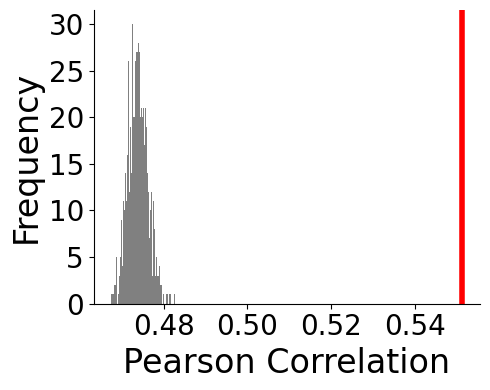

In [44]:
fig,ax = plt.subplots(figsize=(5,4))
plt.hist(dim_corr_null,bins=100,color='gray')
plt.axvline(x=obs_dim_r, color='red',linewidth=4)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.title('Null Distributions and Observed Values (Sorted by Observed Means)')
plt.ylabel('Frequency',fontsize=24)
plt.xlabel('Pearson Correlation',fontsize=24)
# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'Actflow_Dim_prediction_wConnPerm.pdf',transparent=True)

plt.show()

## transformation index

In [45]:
# Read observed transformation distances

with open(subProjDir + 'allsub_actflowpredRSM_sourcecompar.pkl', 'rb') as f:
    RSM_obs_vs_pred_cosSim_sourcecompar = pickle.load(f)
    
trans_dist = 1-RSM_obs_vs_pred_cosSim_sourcecompar

In [46]:
# Read observed sources to target distance

with open(subProjDir + 'allsub_obs_sources_vs_target_cosSim.pkl', 'rb') as f:
        RSM_obs_sources_vs_target_cosSim = pickle.load(f)
        
observed_sourcesToTarget_dist = 1-RSM_obs_sources_vs_target_cosSim

In [56]:
RSM_connperm.shape

(18, 360, 96, 96, 100)

In [57]:
# Null distribution for transformation distance (if computed elsewhere, delete that)

nperm = 100

RSM_obs_vs_pred_cosSim_sourcecompar_connperm = np.zeros((nSub,nParcels,nperm))

for subIdx in range(nSub):

    print(subIdx)
    
    with tqdm(total=nParcels, desc="Progress") as pbar:
    
        for roiIdx in range(nParcels):
            
            for permIdx in range(nperm):
            
                predRSM_flat = RSM_connperm[subIdx,roiIdx,:,:,permIdx].flatten() # pred

                source_indices = np.where(allSubParCorr[subIdx,roiIdx,:]!=0)[0]

                with_allsources_cosSim = []
                for sourceIdx in source_indices:

                    obsRSM_flat = select_sub_taskCondRSM[subIdx,sourceIdx,:,:].flatten() # obs

                    # Compute cosine similarity
                    obsRSM_flat_normed = obsRSM_flat / np.linalg.norm(obsRSM_flat)
                    predRSM_flat_normed = predRSM_flat / np.linalg.norm(predRSM_flat)

                    cosSim = np.dot(obsRSM_flat_normed, predRSM_flat_normed.T)

                    with_allsources_cosSim.append(cosSim)

                meansource_cosSim = np.mean(with_allsources_cosSim)

                RSM_obs_vs_pred_cosSim_sourcecompar_connperm[subIdx,roiIdx,permIdx] = meansource_cosSim
            
            pbar.update(1)

0


Progress: 100%|██████████| 360/360 [03:43<00:00,  1.61it/s]


1


Progress: 100%|██████████| 360/360 [05:08<00:00,  1.17it/s]


2


Progress: 100%|██████████| 360/360 [04:05<00:00,  1.47it/s]


3


Progress: 100%|██████████| 360/360 [05:00<00:00,  1.20it/s]


4


Progress: 100%|██████████| 360/360 [03:48<00:00,  1.58it/s]


5


Progress: 100%|██████████| 360/360 [04:18<00:00,  1.39it/s]


6


Progress: 100%|██████████| 360/360 [04:11<00:00,  1.43it/s]


7


Progress: 100%|██████████| 360/360 [04:47<00:00,  1.25it/s]


8


Progress: 100%|██████████| 360/360 [03:36<00:00,  1.66it/s]


9


Progress: 100%|██████████| 360/360 [04:15<00:00,  1.41it/s]


10


Progress: 100%|██████████| 360/360 [05:25<00:00,  1.11it/s]


11


Progress: 100%|██████████| 360/360 [04:08<00:00,  1.45it/s]


12


Progress: 100%|██████████| 360/360 [05:14<00:00,  1.14it/s]


13


Progress: 100%|██████████| 360/360 [05:08<00:00,  1.17it/s]


14


Progress: 100%|██████████| 360/360 [04:00<00:00,  1.50it/s]


15


Progress: 100%|██████████| 360/360 [05:46<00:00,  1.04it/s]


16


Progress: 100%|██████████| 360/360 [05:08<00:00,  1.17it/s]


17


Progress: 100%|██████████| 360/360 [04:16<00:00,  1.40it/s]


In [58]:
with open(subProjDir + 'allsub_actflowpredRSM_sourcecompar_connperm.pkl', 'wb') as f:
        pickle.dump(RSM_obs_vs_pred_cosSim_sourcecompar_connperm,f)

In [59]:
# Read transformation distance connperm

with open(subProjDir + 'allsub_actflowpredRSM_sourcecompar_connperm.pkl', 'rb') as f:
        RSM_obs_vs_pred_cosSim_sourcecompar_connperm = pickle.load(f)

In [60]:
RSM_obs_vs_pred_cosSim_sourcecompar_connperm.shape

(18, 360, 100)

In [61]:
# Generate 1000 group-level means by bootstrapping

n_groupnull = 1000
groupiter_connperm_cosSim_sourcecompar_mean = np.zeros((nParcels,n_groupnull))

for groupnullIdx in range(n_groupnull):
    
    this_groupiter_connperm_cosSim_sourcecompar = []

    for subIdx in range(nSub):

        this_groupiter_connperm_cosSim_sourcecompar.append(RSM_obs_vs_pred_cosSim_sourcecompar_connperm[subIdx,:,np.random.randint(0, nPerm)])

    groupiter_connperm_cosSim_sourcecompar_mean[:,groupnullIdx] = np.mean(np.array(this_groupiter_connperm_cosSim_sourcecompar),axis=0)
    
groupiter_connperm_cosSim_sourcecompar_mean.shape

(360, 1000)

In [62]:
trans_dist_groupnull = 1-groupiter_connperm_cosSim_sourcecompar_mean

In [63]:
observed_values = np.mean(trans_dist,axis=0)
null_distributions = trans_dist_groupnull
# noise_ceil = np.mean(observed_sourcesToTarget_dist,axis=0)

# Assume observed_values is a (360,) array of observed mean values
# And null_distributions is a (360, 1000) array for null distributions

# Step 1: Sort the regions by observed means
sorted_indices = np.argsort(observed_values)[::-1]  # Sort in descending order

# Reorder the observed values and null distributions
observed_values_sorted = observed_values[sorted_indices]
null_distributions_sorted = null_distributions[sorted_indices, :]

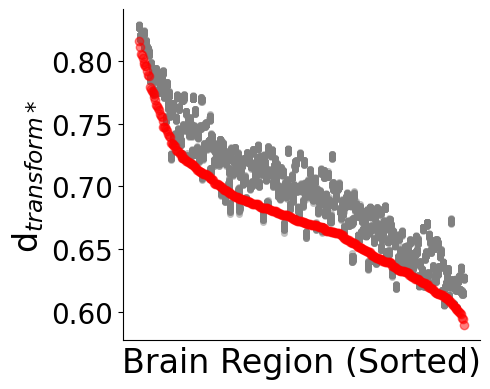

In [64]:
observed_values = np.mean(trans_dist,axis=0)
null_distributions = trans_dist_groupnull
# noise_ceil = np.mean(observed_sourcesToTarget_dist,axis=0)

# Assume observed_values is a (360,) array of observed mean values
# And null_distributions is a (360, 1000) array for null distributions

# Step 1: Sort the regions by observed means
sorted_indices = np.argsort(observed_values)[::-1]  # Sort in descending order

# Reorder the observed values and null distributions
observed_values_sorted = observed_values[sorted_indices]
null_distributions_sorted = null_distributions[sorted_indices, :]
# noise_ceil_sorted = noise_ceil[sorted_indices]

# Step 2: Prepare data for strip plot
data = []
for i in range(nParcels):
    for j in range(nPerm):
        data.append([i, null_distributions_sorted[i, j]])
        
df = pd.DataFrame(data, columns=['Region', 'Null Value'])

# Step 3: Create the strip plot
plt.figure(figsize=(5, 4))

sns.stripplot(x='Region', y='Null Value', data=df, jitter=True, alpha=0.5, color='gray')

# # Overlay the noise ceil
# plt.scatter(x=np.arange(nParcels), y=noise_ceil_sorted, color='black', label=None, zorder=9)

# Overlay the observed values
plt.scatter(x=np.arange(nParcels), y=observed_values_sorted, color='red', alpha=0.5, label=None, zorder=10)
plt.xticks([])
plt.yticks(fontsize=20)

#plt.title('Null Distributions and Observed Values (Sorted by Observed Means)')
plt.xlabel('Brain Region (Sorted)',fontsize=24)
plt.ylabel(r'd$_{transform*}$',fontsize=24)
# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'Actflow_TransformationDistance_wConnPerm.pdf',transparent=True)

plt.show()

In [65]:
print(observed_values_sorted.shape)
print(null_distributions_sorted.shape)

(360,)
(360, 1000)


In [68]:
n_instances = np.sum(np.tile(observed_values_sorted,(1000,1)).T < null_distributions_sorted, axis=1)
pval = n_instances/1000

In [69]:
np.sum(pval<0.001)

14

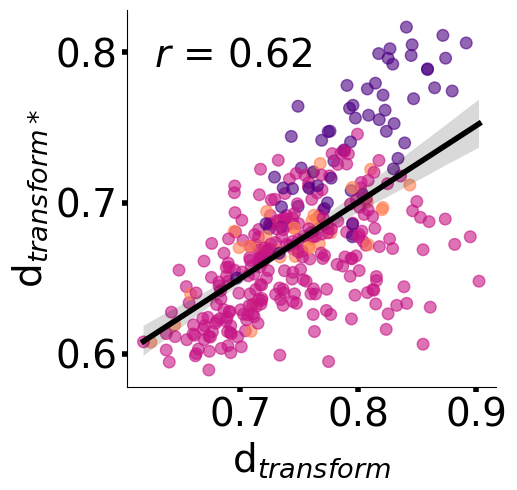

In [48]:
X = np.mean(observed_sourcesToTarget_dist,axis=0)
Y = np.mean(trans_dist,axis=0)
RAaxis = 'full_BS'
xlabel = r'd$_{transform}$'
ylabel = r'd$_{transform*}$'
outname = figoutdir + 'observed_vs_pred_dtrans.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='TL',xmin=None,xmax=None,ymin=None,ymax=None,
                            invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.25,showstat=True)

In [36]:
# Significance:

X = observed_sourcesToTarget_dist
Y = trans_dist

RSMtools.acrossSub_tTestStats(X,Y,nSub=nSub)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  9.1262 2.0000 34.0000 0.0007

t_full,p_full:  19.596084089913283 4.176004792374863e-13
t_sensory,p_sensory:  19.39607061893284 4.936649914781841e-13
t_association,p_association:  16.188851454793056 9.175813854098151e-12
t_motor,p_motor:  11.191588819014875 2.90230638517316e-09
t_SenAsso,p_SenAsso:  6.673046330549436 3.924535827504676e-06 Corr. p= 1.1773607482514027e-05
t_AssoMot,p_AssoMot:  -2.4203676553337883 0.02698988381462669 Corr. p= 0.08096965144388008
t_SenMot,p_SenMot:  1.2289024831596307 0.23584860253782924 Corr. p= 0.7075458076134877


## Checking RSM transformation due to random weights

In [25]:
# Read transformation distance for random transformations of source RSMs

with open(subProjDir + 'allsub_actflowpredRSM_sourcecompar_randomTrans.pkl', 'rb') as f:
        allsub_RSM_obs_vs_randomTrans_cosSim_sourcecompar = pickle.load(f)

In [26]:
# Generate 1000 group-level means by bootstrapping

n_groupnull = 1000
groupiter_randomTrans_cosSim_sourcecompar_mean = np.zeros((nParcels,n_groupnull))

for groupnullIdx in range(n_groupnull):
    
    this_groupiter_randomTrans_cosSim_sourcecompar = []

    for subIdx in range(nSub):

        this_groupiter_randomTrans_cosSim_sourcecompar.append(allsub_RSM_obs_vs_randomTrans_cosSim_sourcecompar[subIdx,:,np.random.randint(0, nPerm)])

    groupiter_randomTrans_cosSim_sourcecompar_mean[:,groupnullIdx] = np.mean(np.array(this_groupiter_randomTrans_cosSim_sourcecompar),axis=0)
    
groupiter_randomTrans_cosSim_sourcecompar_mean.shape

(360, 1000)

In [27]:
trans_dist_groupnull = 1-groupiter_randomTrans_cosSim_sourcecompar_mean

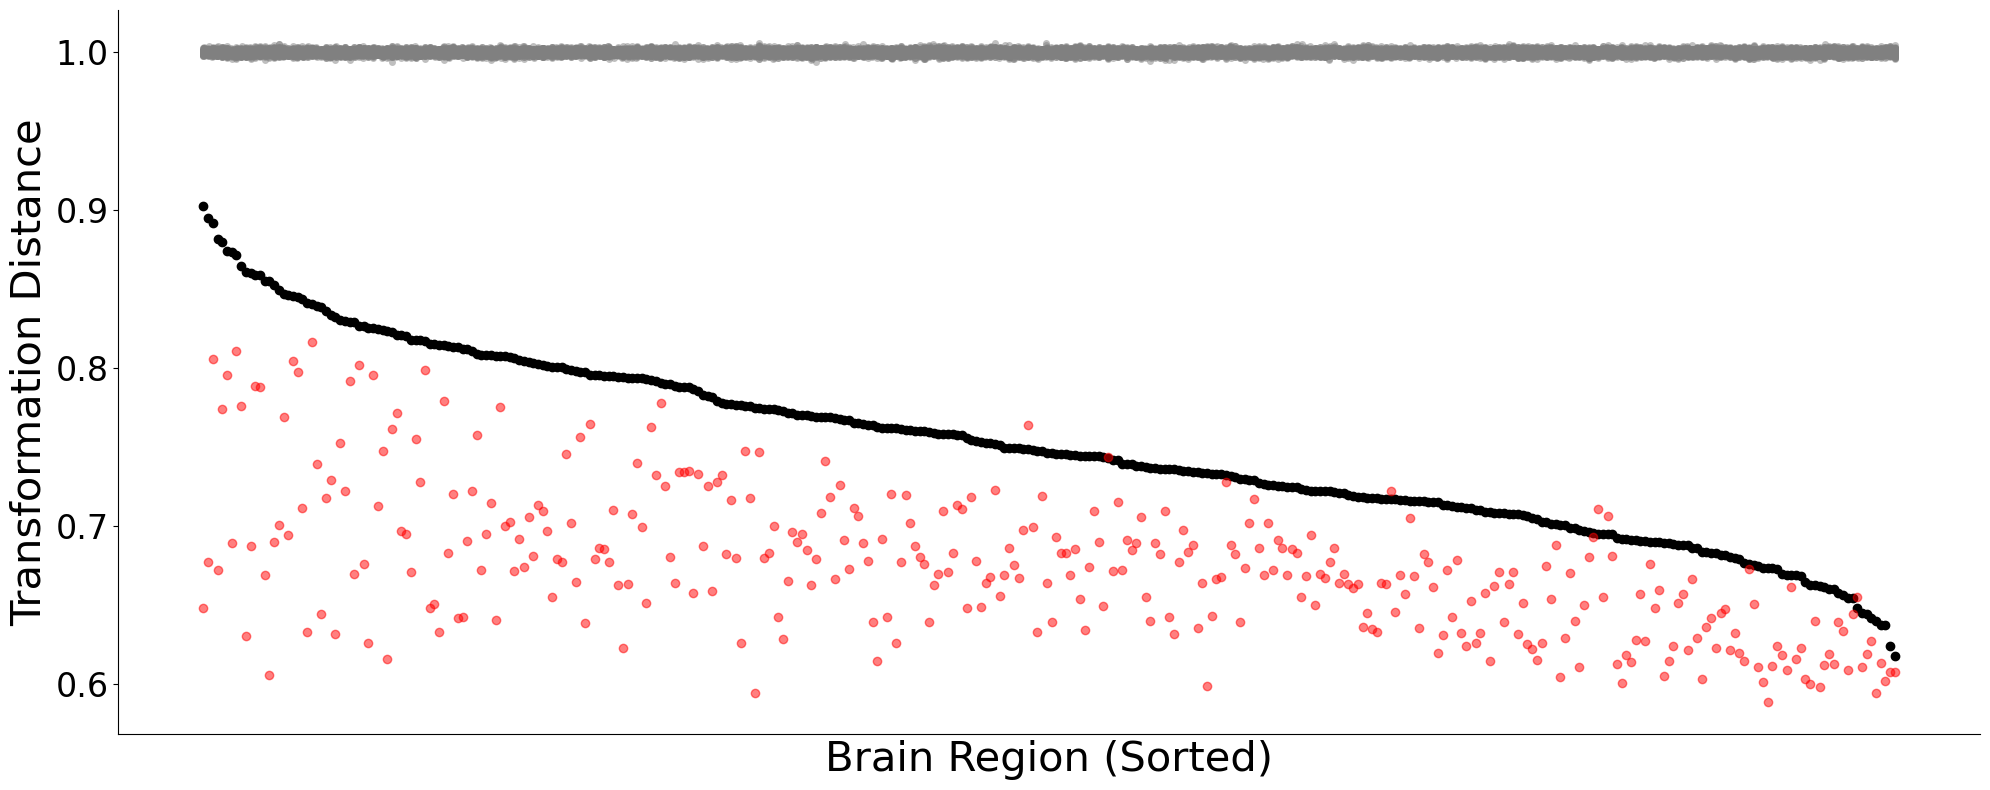

In [28]:
observed_values = np.mean(trans_dist,axis=0)
null_distributions = trans_dist_groupnull
noise_ceil = np.mean(observed_sourcesToTarget_dist,axis=0)

# Assume observed_values is a (360,) array of observed mean values
# And null_distributions is a (360, 1000) array for null distributions

# Step 1: Sort the regions by observed means
sorted_indices = np.argsort(noise_ceil)[::-1]  # Sort in descending order

# Reorder the observed values and null distributions
observed_values_sorted = observed_values[sorted_indices]
null_distributions_sorted = null_distributions[sorted_indices, :]
noise_ceil_sorted = noise_ceil[sorted_indices]

# Step 2: Prepare data for strip plot
data = []
for i in range(nParcels):
    for j in range(nPerm):
        data.append([i, null_distributions_sorted[i, j]])
        
df = pd.DataFrame(data, columns=['Region', 'Null Value'])

# Step 3: Create the strip plot
plt.figure(figsize=(20, 8))

sns.stripplot(x='Region', y='Null Value', data=df, jitter=True, alpha=0.5, color='gray')

# Overlay the noise ceil
plt.scatter(x=np.arange(nParcels), y=noise_ceil_sorted, color='black', label=None, zorder=9)

# Overlay the observed values
plt.scatter(x=np.arange(nParcels), y=observed_values_sorted, color='red', alpha=0.5, label=None, zorder=10)
plt.xticks([])
plt.yticks(fontsize=24)

#plt.title('Against random linear transformation for null')
plt.xlabel('Brain Region (Sorted)',fontsize=30)
plt.ylabel('Transformation Distance',fontsize=30)
# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'Actflow_TransformationDistance_wRandomTrans_zeromean.pdf',transparent=True)

plt.show()